![QuantConnect Logo](https://cdn.quantconnect.com/web/i/logo-small.png)
 
Refer to this page for documentation https://www.quantconnect.com/docs#Introduction-to-Jupyter

Contribute to this file https://github.com/QuantConnect/Research/tree/master/Notebooks

## EMA Cross Strategy
In this research we will demonstrate a simple EMA cross strategy and how to generate the equity curve for this strategy.
- Check the algorithm implementation on LEAN 

https://www.quantconnect.com/terminal/processCache/?request=embedded_backtest_e171fd2869c47c15dac0ec26409d85ec.html

Here we ignore the fees when we generate the profit curve so the statistics result might be slightly different from the LEAN implementation.

In [1]:
%matplotlib inline
# Imports
from clr import AddReference
AddReference("System")
AddReference("QuantConnect.Common")
AddReference("QuantConnect.Jupyter")
AddReference("QuantConnect.Indicators")
from System import *
from QuantConnect import *
from QuantConnect.Data.Market import TradeBar, QuoteBar
from QuantConnect.Jupyter import *
from QuantConnect.Indicators import *
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import ceil, floor
# Create an instance
qb = QuantBook()
plt.style.use('seaborn-whitegrid')

### Step 0:
First we define some functions that we need to generate the equity curve.

In [4]:
def calculateQuantity(signal, price, cash):
    """
    This function calculate the quantity based on the signal and initial cash 
    
    Parameters:
            signal(pandas.Series): The trading signal series of stock indexed by date (long 1, short -1, holding 0)
            price(pandas.Series) : The price series of stock indexed by date
            cash(float): The total cash for trading
    
    Returns(pandas.Series):
            quantity(pandas.Series): The number of holding shares indexed by date 
    """

    index = np.where(signal.shift(1) != signal)[0][1:]
    quantity_temp = floor(cash/price[0])
    cash_left_temp = cash
    quantity = [quantity_temp]
    cash_left = [cash_left_temp]

    for i in range(1,len(price)):
        if i in index:
            if signal[i-1] * signal[i] == -1:
                cash_left_liquidate = cash_left[i-1] + (signal[i-1]- 0) * quantity[-1] * price[i]                    
                quantity_temp = floor(cash_left_liquidate / price[i])
                cash_left_temp = cash_left_liquidate + (0 - signal[i]) * quantity_temp * price[i] 
 
                if quantity_temp == 0:
                    # print("{0} Order Failed (No enough money)  Cash left: {1} share price: {2}".format(signal.index[i],cash_left_temp,price[i]))                    
                    quantity_temp =  quantity[i-1]
                
                if cash_left_liquidate < 0:
                    quantity_temp = 0
                                         
            elif signal[i-1] * signal[i] == 0:
                quantity_temp = floor(cash_left[i-1] / price[i])
                cash_left_temp = cash_left[i-1] + (signal[i-1]- signal[i]) * quantity_temp * price[i]        
                    
                if quantity_temp == 0:
                    # print("{0} Order Failed (No enough money)  Cash left: {1} share price: {2}".format(signal.index[i],cash_left_temp,price[i]))
                    quantity_temp =  quantity[i-1]
                       
        quantity.append(quantity_temp)
        cash_left.append(cash_left_temp)
   
    return pd.Series(quantity, index = signal.index)

In [6]:
class NetProfit:
    """
    This class calculates the net profit for strategy trading individual stock
    
    Args:
        price(pandas.Series) : The price series of stock indexed by date
        signal(pandas.Series): The trading signal series of stock indexed by date (long 1, short -1, holding 0)

    Attributes:
        price(pandas.Series) : The price series of stock indexed by date
        signal(pandas.Series): The trading signal series of stock indexed by date (long 1, short -1, holding 0)
        quantity(pandas.Series): The number of holding shares indexed by date 
    
    Note:
        If there is no quantity, the default value of quantity is 1 share at each time step)       
    """
    
    def __init__(self, price, signal):
        self.price = price
        self.signal = signal
        self.quantity = pd.Series([1]*len(self.price),index = self.price.index)
        
        
    def net_profit(self):
       
        """
        calculate the net profit
        
        Returns(pandas.Series):
                The net profit for strategy        
        """
        #   log_return = np.log(self.price/self.price.shift(1))
        #   cum_return = np.exp(((log_return)*self.signal.shift(1)).cumsum())*self.quantity
        pct_return = self.price.pct_change()
        cum_return = ((pct_return)*self.signal.shift(1) + 1).cumprod()*self.quantity 
        net_profit = cum_return.dropna()*self.price[0] 
        return net_profit   
    
class PortfolioNetProfit:
    """
    This class calculates the net profit for strategy trading a porfolio of stocks or singal stock
    
    Args:
        data(dict): A dictionary stores the data for multiple stocks 
                    keys(string): 
                                symbols
                    values(dataframe): 
                                Index: date 
                                Columns: ['price','signal','quantity'] or ['price','signal']         
    """
    
    def __init__(self,data):
        self.data = data
        
    def net_profit(self):
        """
        Calculate the net profit for the portfolio
        
        Returns(pandas.Series):
                The net profit for strategy
            
        """
        dataframe = self.data[list(self.data.keys())[0]]
        net_profit_port = pd.Series([0]*(len(dataframe)),index = dataframe.index)
       
        for i in self.data:
            df = self.data[i]
            net_profit_each = NetProfit(df['price'],df['signal'])
            try:
                net_profit_each.quantity = df['quantity'] # if there is no quantity, the default is 1 
            except:
                pass
            cum_return = net_profit_each.net_profit()
            net_profit_port = net_profit_port.add(cum_return,fill_value=0)        

        return net_profit_port[1:]
    
    def curve(self):
        """
        Plot the equity curve for strategy contain a portfolio of stocks
        """
        net_profit_port = self.net_profit()
        plt.figure(figsize =(15,7))
        plt.plot(net_profit_port.index, net_profit_port,label ='Portfolio Net Profit ($)')
        plt.legend()        


 ### Step 1:
First, we develop a simple strategy using VXX indicator and generate the trading signals. The strategy is as follows:

Go long the ETFs in the portfolio when the 30-day exponential moving average (EMA) of VXX cross the close from the top, short the ETFs when the 30-day EMA of VXX cross the close from the bottom. The portfolio includes five index ETFs.

In [7]:
symbols = ["VXX","SPY","IWM","DIA"]
data = {}
for syl in symbols:
    qb.AddEquity(syl)
    data[syl] = qb.History([syl], datetime(2010,1,1), datetime.now(), Resolution.Daily).loc[syl]['close']
    data[syl].index = data[syl].index.date
df_price = pd.DataFrame(data, columns=data.keys())

In [8]:
# Generate the EMA indicator for VXX 
days=len(df_price)
ema = qb.Indicator(ExponentialMovingAverage(10), "VXX", days, Resolution.Daily)
ema.columns = ['EMA']
df = pd.concat([ema,df_price], axis=1, join='inner')


In [9]:
# Generate the trading signals
signal = pd.Series([np.nan]*len(df),index =df.index)
sell = (df['VXX'] > df['EMA']) & (df['VXX'].shift(1) < df['EMA'])                      
buy = (df['VXX'] < df['EMA']) & (df['VXX'].shift(1) > df['EMA'])

for i in range(len(df)):
    if sell[i]:
        signal[i] = 0
    elif buy[i]:
        signal[i] = 1        
df['signal'] = signal.fillna(method='ffill').fillna(0)

### Step 2:
Store the price, signal and holding shares quantity in a dictionary keyed by symbols. The quantity is calculated using our function by setting the initial cash and inputting the signal and price.

In [10]:
# here we choose the quantity to be 2 shares for each ETFs 
# if there is no 'quantity' in dataframe, the default quantity is 1
# The dictionary could only contain one stock
total_cash = 100000
cash_each = total_cash / len(symbols[1:])
data_dict = {}
for i in symbols[1:]:
    data_dict[i] = pd.DataFrame({'price':df[i].values,
                                 'signal':df['signal'].values,
                                 'quantity':calculateQuantity(df['signal'].shift(1), df[i], cash_each)}, index = df[i].index)   
        

### Step 3:
Calculate the net profit for the strategy and plot the equity curve. Use "SPY" as the benchmark.

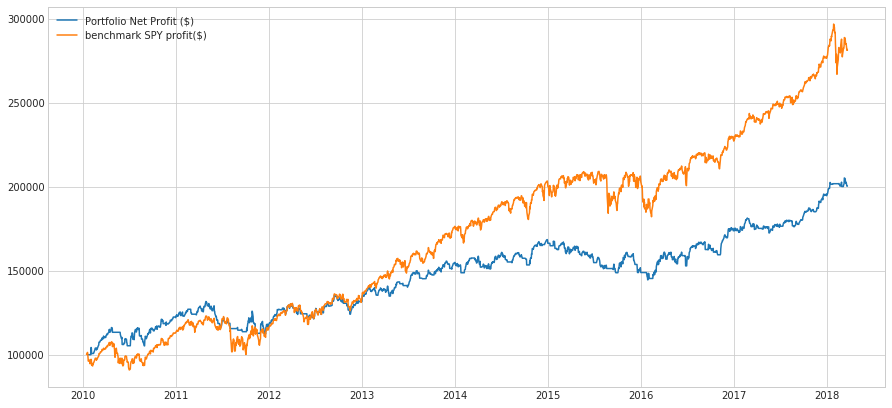

In [11]:
profit_strategy = PortfolioNetProfit(data_dict).net_profit()
profit_benchmark = (df['SPY'])*(total_cash/df['SPY'][0])
# plot the equity curve for the strategy
PortfolioNetProfit(data_dict).curve() 
# plot the equity curve for the benchmark
plt.plot(profit_benchmark, label='benchmark SPY profit($)')
plt.legend()

### Step 4:
Calculatet the statistics to evaluate the performance of the strategy.
How to calculate the strategy statistics?

- *GetPortfolioStatistics(PyObject dataFrame)*

GetPortfolioStatistics API gets portfolio Statistics from a pandas.DataFrame with equity and benchmark values. The columns are 'benchmark' and 'equity'. The value is the cumulative profit of the strategy and the benchmark(buy and hold the benchmark equity strategy).

Refer to the QuantBook on Github for details:
https://github.com/QuantConnect/Lean/blob/cc46cd367f5a0c415e6ac2462b903a27a86eedcb/Jupyter/QuantBook.cs#L505

In [12]:
performance = pd.concat([profit_benchmark,profit_strategy],axis=1)[1:]
performance.columns = ['benchmark','equity']

In [13]:
stats = qb.GetPortfolioStatistics(performance)

In [14]:
stats

{'Alpha': 0.025626879608200377,
 'Annual Standard Deviation': 0.108615810217864,
 'Annual Variance': 0.011797394229283118,
 'Average Loss (%)': -3.0145964146246155e-06,
 'Average Win (%)': 5.671196388120762e-06,
 'Beta': 0.481217139398708,
 'Compounding Annual Return (%)': 8.88316669670892,
 'Drawdown (%)': 14.7,
 'Expectancy': 0.12001774494578009,
 'Information Ratio': -0.40003765498221394,
 'Loss Rate (%)': 61.12730806608357,
 'Net Profit (%)': 100.47742283569691,
 'Profit-Loss Ratio': 1.8812456488730194,
 'Sharpe Ratio': 0.8385125945061834,
 'Tracking Error': 0.112317332786866,
 'Treynor Ratio': 0.18926118247569823,
 'Win Rate (%)': 38.87269193391642}